In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import random

### read data

In [2]:
path = "comments_data/"
angry = pd.read_csv(os.path.join(path,"angry.txt"),header=None)
sad = pd.read_csv(os.path.join(path,"sad.txt"),header=None)
love = pd.read_csv(os.path.join(path,"love.txt"),header=None)
haha = pd.read_csv(os.path.join(path,"haha.txt"),header=None)

In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
# angry["label"] = 0
# sad["label"] = 1

### labels angry 0 sad 1 haha 2 love 3

In [5]:
total_dataframe = []
total_dataframe.append(angry)
total_dataframe.append(sad)
total_dataframe.append(haha)
total_dataframe.append(love)

In [6]:
total_dataframe[3].shape

(1953, 1)

In [7]:
import copy
def create_labels(data_frame):
    total_labels = []
    for i in range(4):
        total_labels.append(np.zeros(data_frame[i].shape))
        total_labels[i]+=i
    labels_array = copy.deepcopy(total_labels[0])
    for i in range(3):
        labels_array = np.append(labels_array,total_labels[i+1])
    return np.array(labels_array,dtype=np.int)

In [8]:
labels_array = create_labels(total_dataframe)
print(labels_array)

[0 0 0 ... 3 3 3]


In [9]:
def data_split(data_frame,labels):
    index = np.arange(len(labels_array))
    np.random.shuffle(index)
    start = int(len(index)/10)
    print(start)
    test_index = index[:start]
    train_index = index[start:len(index)]
    print(test_index.shape)
    train_values,train_labels = data_frame.values[train_index],labels_array[train_index]
    test_values,test_labels = data_frame.values[test_index],labels_array[test_index]
    
    train_values = pd.DataFrame(train_values)
    train_values.to_csv(os.path.join(path,"total_train_value.csv"))
    
    test_values = pd.DataFrame(test_values)
    test_values.to_csv(os.path.join(path,"total_test_value.csv"))
    
    train_labels = pd.DataFrame(train_labels)
    train_labels.to_csv(os.path.join(path,"total_train_label.csv"))
    
    test_labels = pd.DataFrame(test_labels)
    test_labels.to_csv(os.path.join(path,"total_test_label.csv"))

data_split(angry.append(sad).append(haha).append(love),labels_array)

1520
(1520,)


In [10]:
def data_frame_integrate(data_frame_list):
    assert len(data_frame_list) >= 2
    res = data_frame_list[0]
    for i in range(1,len(data_frame_list)):
        res = res.append(data_frame_list[i])
#     print(res.shape)
    return res
def data_balanced_split(data_frame_list):
    length_list = [len(elem) for elem in data_frame_list]
    min_length = np.min([len(elem) for elem in data_frame_list])
    
    random_index_list = [np.arange(len(elem)) for elem in data_frame_list]
    for i in range(len(random_index_list)):
        random.shuffle(random_index_list[i])
    random_index_list = np.array([elem[:min_length] for elem in random_index_list])

    offset_lam = lambda x,i: sum([x[j] for j in range(i)])
#     sum_lam = lambda x: sum([len(elem) for elem in x])
    offset_list = [offset_lam(length_list,i) for i in range(len(random_index_list))]
    for i in range(len(data_frame_list)):
        random_index_list[i]+= offset_list[i]
        
    for i in range(len(data_frame_list)):
        assert (max(random_index_list[i]) - min(random_index_list[i])) > 0.9*len(data_frame_list[i])
    assert (random_index_list[0]<random_index_list[1]).all()


    index = random_index_list.reshape((min_length*len(data_frame_list),))
    random.shuffle(index)
#     print(index.shape)

    start = int(index.shape[0]/10)
    print("start",start)
#     labes_array = [np.zeros(len(data_frame_list)) for i in range]
    test_index = index[:start]
    train_index = index[start:len(index)]

    data_frame = data_frame_integrate(data_frame_list)
    
    train_values,train_labels = data_frame.values[train_index],labels_array[train_index]
    test_values,test_labels = data_frame.values[test_index],labels_array[test_index]
#     print(test_index)
    train_values = pd.DataFrame(train_values)
    train_values.to_csv(os.path.join(path,"balanced_train_value.csv"))
    
    test_values = pd.DataFrame(test_values)
    test_values.to_csv(os.path.join(path,"balanced_test_value.csv"))
    
    train_labels = pd.DataFrame(train_labels)
    train_labels.to_csv(os.path.join(path,"balanced_train_label.csv"))
    
    test_labels = pd.DataFrame(test_labels)
    test_labels.to_csv(os.path.join(path,"balanced_test_label.csv"))

data_balanced_split(total_dataframe)

start 442


### overview of the data

In [11]:
def sentence_to_word_array(data_frame):
    temp = data_frame.values
    new_array = [str(element).split(" ") for element in temp]
    return new_array

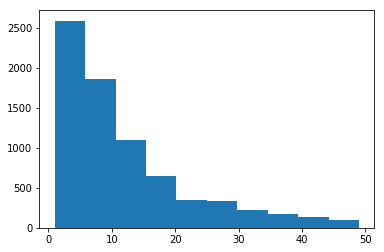

percentage of less than 50 words:  0.9508798582099


In [12]:
from scipy.stats.mstats import mode
import matplotlib.pyplot as plt
angry_example = sentence_to_word_array(angry)
length_array = np.array([len(elem) for elem in angry_example])
# length_dict = np.
short = length_array[length_array<50]
plt.hist(short)
plt.show()
percentage = sum(length_array<50)/len(length_array)
print("percentage of less than 50 words: ", percentage)

### tokenizer for all

In [13]:
import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
total_comments = angry.append(sad).append(haha).append(love)

def tokenizer_in_total(data_frame,max_tokenizer_words):
    temp_tokenizer = Tokenizer(num_words=max_tokenizer_words+1,lower=True,filters=' ',split=' ',oov_token='UNK')
    temp_tokenizer.fit_on_texts(data_frame)
    temp_tokenizer.word_index = {elem:i for elem,i in temp_tokenizer.word_index.items() if i<=max_tokenizer_words}
    return temp_tokenizer

In [17]:
total_comments = angry.append(sad).append(haha).append(love)
total_comments.values[0]
comments_tokenizer = tokenizer_in_total(total_comments[0],10000)

In [18]:
def to_tokens(tokenizer,sentences,max_words):
    return pad_sequences(tokenizer.texts_to_sequences(sentences),
                        maxlen=max_words,
                         padding='post',truncating='post')   

total_comments.shape

In [27]:
total_comments[0:1].values

array([['despite its propaganda of family values and religiosity the obamacare repeal effort exposed is that the only god republicans worship is the republican party and the dollarthis country has been hopelessly given over to a reprobate mind']],
      dtype=object)

### tokenizer for balanced subset

In [120]:
balanced_train_value_df = pd.read_csv(os.path.join(path,"balanced_train_value.csv"))
balanced_train_label_df = pd.read_csv(os.path.join(path,"balanced_train_label.csv"))
balanced_test_value_df = pd.read_csv(os.path.join(path,"balanced_test_value.csv"))
balanced_test_label_df = pd.read_csv(os.path.join(path,"balanced_test_label.csv"))
total_balanced_comments = balanced_train_value_df.append(balanced_test_value_df)

In [121]:
total_balanced_comments.shape

(4420, 2)

In [122]:
balanced_tokenizer = tokenizer_in_total(total_balanced_comments["0"],10000)

### load the pre-trained word-to-vector from golve

In [123]:
import csv
from pathlib import Path
glove_embedding_path = os.path.join(
    "~/data/emotion_detection/data/glove/glove.twitter.27B/glove.twitter.27B.200d.txt")
glove_index = pd.read_table(glove_embedding_path,
                            sep=" ",index_col=0,
                            header=None,quoting=csv.QUOTE_NONE)

In [124]:
glove_mean = np.mean(glove_index.mean())
glove_std = np.mean(glove_index.std())
glove_size = len(glove_index.columns)
comments_tokenizer_index = comments_tokenizer.word_index
embedding_matrix = np.random.normal(glove_mean,glove_std,(10000+2,glove_size))
for word,i in comments_tokenizer_index.items():
    if word in comments_tokenizer_index.items():
        embedding_matrix[i,:]=glove_index.loc[word].values

In [125]:
balanced_tokenizer_index = balanced_tokenizer.word_index
balanced_embedding_matrix = np.random.normal(glove_mean,glove_std,(10000+2,glove_size))
for word,i in balanced_tokenizer_index.items():
    if word in balanced_tokenizer_index.items():
        balanced_embedding_matrix[i,:]=glove_index.loc[word].values

In [126]:
X_train_df = pd.read_csv(os.path.join(path,"total_train_value.csv"))
X_test_df = pd.read_csv(os.path.join(path,"total_test_value.csv"))

In [127]:
X_train = to_tokens(comments_tokenizer,X_train_df['0'],50)
X_test = to_tokens(comments_tokenizer,X_test_df['0'],50)

In [128]:
y_train = pd.read_csv(os.path.join(path,"total_train_label.csv"))['0']
y_test = pd.read_csv(os.path.join(path,"total_test_label.csv"))['0']

In [129]:
balanced_X_train = to_tokens(balanced_tokenizer,balanced_train_value_df['0'],50)
balanced_X_test = to_tokens(balanced_tokenizer,balanced_test_value_df['0'],50)
balanced_y_train = balanced_train_label_df["0"]
balanced_y_test = balanced_test_label_df["0"]

In [133]:
# balanced_test_value_df

In [134]:
# balanced_y_test

In [135]:
# balanced_test_label_df

In [136]:
import keras.backend as K
from keras.layers import Input,Dense,Embedding,Dropout, Activation
from keras.layers import Flatten, Conv1D,MaxPooling1D
from keras.layers import LSTM, Bidirectional
from keras.models import Model,Sequential
from keras import initializers,regularizers,optimizers,layers,constraints
from keras.utils import np_utils,multi_gpu_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

In [137]:
cag_y_train = np_utils.to_categorical(y_train)
cag_y_test = np_utils.to_categorical(y_test)
balanced_cag_y_train = np_utils.to_categorical(balanced_y_train)
balanced_cag_y_test = np_utils.to_categorical(balanced_y_test)

In [138]:
def deepLSTM1():
    inp = Input(shape=(50,), name='input')
    x = Embedding(10000+2, glove_size, weights=[embedding_matrix], name='embedding')(inp)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1, name='conv1')(x)
    x = MaxPooling1D(pool_size=4, name='maxpool1')(x)
#     x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm1')(x)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm2')(x)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm3')(x)

    x = Flatten()(x)
    x = Dense(100, activation='relu', name='dense1')(x)
    x = Dense(50, activation='relu', name='dense2')(x)
    x = Dense(4, activation='sigmoid', name='dense3')(x)
    model = Model(input=inp, output=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [139]:
network_func = deepLSTM1
model = network_func()

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [140]:
# model.fit(X_train, cag_y_train, batch_size=32, epochs=10, validation_split=0.1)
# print('Acc:', model.evaluate(X_test, cag_y_test, batch_size=32)[1])

In [141]:
balanced_cag_y_test.shape

(442, 4)

In [142]:
model.fit(balanced_X_train, balanced_cag_y_train, batch_size=32, epochs=10, validation_split=0.1)
print('Acc:', model.evaluate(balanced_X_test, balanced_cag_y_test, batch_size=32)[1])

Train on 3580 samples, validate on 398 samples
Epoch 1/10
3580/3580 [==============================] - 15s 4ms/step - loss: 1.3853 - acc: 0.2640 - val_loss: 1.3761 - val_acc: 0.2462
Epoch 2/10
3580/3580 [==============================] - 9s 2ms/step - loss: 1.3561 - acc: 0.3212 - val_loss: 1.3584 - val_acc: 0.3367
Epoch 3/10
3580/3580 [==============================] - 9s 3ms/step - loss: 1.1990 - acc: 0.4494 - val_loss: 1.2866 - val_acc: 0.3920
Epoch 4/10
3580/3580 [==============================] - 9s 2ms/step - loss: 1.0438 - acc: 0.5427 - val_loss: 1.2981 - val_acc: 0.4045
Epoch 5/10
3580/3580 [==============================] - 9s 3ms/step - loss: 0.8352 - acc: 0.6388 - val_loss: 1.3611 - val_acc: 0.4221
Epoch 6/10
3580/3580 [==============================] - 9s 3ms/step - loss: 0.6786 - acc: 0.7176 - val_loss: 1.5646 - val_acc: 0.4070
Epoch 7/10
3580/3580 [==============================] - 9s 3ms/step - loss: 0.5580 - acc: 0.7737 - val_loss: 1.6513 - val_acc: 0.4196
Epoch 8/10
358

In [143]:
def accuracy(model,X_test,y_test):
    y_predict = model.predict(X_test)
    y_predict = np.array([np.argmax(elem) for elem in y_predict])
    res = sum(y_predict==y_test)/len(y_test)
    return res
def error_collection(X_test_df,y_test,y_predict,file_name):
    print(y_test.shape)
    print(y_predict.shape)
    string_list = ["angry","sad","haha","love"]
    error_set = X_test_df[y_predict!=y_test]
    groud_truth = [string_list[i] for i in y_test[y_predict!=y_test]]
    prediction = [string_list[i] for i in y_predict[y_predict!=y_test]]
    content = []
    content.append(groud_truth)
    content.append(prediction)
    content.append(list(error_set.values[:,1]))
    temp_df = pd.DataFrame(content)
    temp_df.rename(columns={"0":"truth","1":"prediction","2":"content"})
    temp_df = temp_df.transpose()
    temp_df.to_csv(file_name)
#     return error_set.values[:,1]

In [144]:
balanced_y_predict = model.predict(balanced_X_test)
balanced_y_predict = np.array([np.argmax(elem) for elem in balanced_y_predict])

In [145]:
error_collection(balanced_test_value_df,balanced_y_test,balanced_y_predict,"balanced_test_2.csv")
error_set = pd.read_csv("balanced_test_2.csv")
print("error angry percentage",list(error_set["0"]).count("angry")/error_set.shape[0])
print("error sad percentage",list(error_set["0"]).count("sad")/error_set.shape[0])
print("error haha percentage",list(error_set["0"]).count("haha")/error_set.shape[0])
print("error love percentage",list(error_set["0"]).count("love")/error_set.shape[0])

(442,)
(442,)
error angry percentage 0.20434782608695654
error sad percentage 0.25217391304347825
error haha percentage 0.2608695652173913
error love percentage 0.2826086956521739


In [146]:
def count_predict(predict,label,cag):
    predict[label==cag]==cag

In [147]:
from prettytable import PrettyTable
conf_matrix = PrettyTable()

conf_matrix.field_names = ["label\\pre","angry", "sad", "haha", "love"]

conf_matrix.add_row(["angry", 
                     sum(balanced_y_predict[balanced_y_test==0]==0),
                     sum(balanced_y_predict[balanced_y_test==0]==1),
                     sum(balanced_y_predict[balanced_y_test==0]==2),
                     sum(balanced_y_predict[balanced_y_test==0]==3)])
conf_matrix.add_row(["sad", 
                     sum(balanced_y_predict[balanced_y_test==1]==0),
                     sum(balanced_y_predict[balanced_y_test==1]==1),
                     sum(balanced_y_predict[balanced_y_test==1]==2),
                     sum(balanced_y_predict[balanced_y_test==1]==3)])
conf_matrix.add_row(["haha", 
                     sum(balanced_y_predict[balanced_y_test==2]==0),
                     sum(balanced_y_predict[balanced_y_test==2]==1),
                     sum(balanced_y_predict[balanced_y_test==2]==2),
                     sum(balanced_y_predict[balanced_y_test==2]==3)])
conf_matrix.add_row(["love", 
                     sum(balanced_y_predict[balanced_y_test==3]==0),
                     sum(balanced_y_predict[balanced_y_test==3]==1),
                     sum(balanced_y_predict[balanced_y_test==3]==2),
                     sum(balanced_y_predict[balanced_y_test==3]==3)])

print(conf_matrix)


+-----------+-------+-----+------+------+
| label\pre | angry | sad | haha | love |
+-----------+-------+-----+------+------+
|   angry   |   60  |  20 |  16  |  11  |
|    sad    |   35  |  59 |  6   |  17  |
|    haha   |   41  |  7  |  49  |  12  |
|    love   |   26  |  34 |  5   |  44  |
+-----------+-------+-----+------+------+


In [148]:
def two_classes_accuracy(y_test,y_predict):
    comb = np.array([y_test,y_predict])
    count = [1 if abs(i[0]-i[1])<=1 and (i[0]+i[1])!=5 else 0 for i in comb.T]
    return sum(count)/len(y_test)

In [149]:
print("two_classes_accuracy",two_classes_accuracy(balanced_y_test, balanced_y_predict))

two_classes_accuracy 0.6334841628959276


In [67]:
# def error_plot(,y_predict):
#     f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#     ax1.plot(x, y)
#     ax2.scatter(x, y)

In [ ]:
def create_embedding():
    inp = Input(shape=(50,), name='input')
    x = Embedding(10000+2, glove_size, weights=[embedding_matrix], name='embedding')(inp)
    model = Model(input=inp,output=x)
    model.compile(optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
# embedding_create = create_embedding()

In [ ]:
embedding_create.fit(X_train)

In [47]:
pd.read_csv("annotated_lem.csv",header=None).iloc[:,1:2]

,1
0,i love how liberal keep say the same thing tha...
1,lol 1 million new job 11000 less federal job b...
2,his new general be suppose to keep him in chec...
3,no it doesnt ilive in arizona and we be fine h...
4,arizona be turn blue in no time it go in a tre...
5,if trump wasnt a racist ignorant bigot he woul...
6,donald trump be on a path to become cemented i...
7,blame the establishment rino republican and al...
8,well be still wait to see his amaze wonderful ...
9,oh cnn lmmfao youre always misinform arent you...


In [67]:
from ftrgen import LexiconFeatures
lexftr = LexiconFeatures(lexicondir=os.path.join('emd_data/lexicons/'))
lexiconsPath = 'temp.csv'
lexftr.build(path=lexiconsPath)
lexftr.load(path=lexiconsPath)
X_train_lex = lexftr.vectorizeDataset(pd.read_csv("annotated_lem.csv")["content"])
# X_dev_lex = lexftr.vectorizeDataset(pd.read_csv("test_annotation.csv")["valance"])
X_train_lex = X_train_lex[[c for c in X_train_lex.columns if c != 'tweet']].values
# X_dev_lex = X_dev_lex[[c for c in X_dev_lex.columns if c != 'tweet']].values
y_train_lex = pd.read_csv("test_annotation.csv",encoding = "ISO-8859-1")["valance"]

In [68]:
y_train_lex[y_train_lex==0]=1

In [69]:
X_train_lex

array([[2.        , 1.        , 5.        , ..., 1.81895348, 1.59862419,
        3.05839342],
       [1.        , 1.        , 2.        , ..., 0.31445143, 0.76441477,
        1.98796245],
       [1.        , 6.        , 1.        , ..., 1.34859016, 1.27534351,
        2.55683547],
       ...,
       [4.        , 2.        , 7.        , ..., 1.48308502, 1.86509631,
        4.22515118],
       [2.        , 1.        , 3.        , ..., 2.78388834, 1.78369785,
        3.94216217],
       [2.        , 2.        , 5.        , ..., 2.33929821, 1.87791113,
        3.76413187]])

In [118]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=16,max_depth=100)
rfc.fit(X_train_lex[0:80],y_train_lex[0:80])
rfc_y = rfc.predict(X_train_lex[80:100])
print(sum(rfc_y==(y_train_lex[80:100]))/20)

0.4


In [116]:
(rfc_y==y_train_lex[80:100])

80    False
81    False
82     True
83    False
84    False
85     True
86     True
87     True
88     True
89    False
90    False
91     True
92    False
93    False
94    False
95     True
96     True
97     True
98    False
99     True
Name: valance, dtype: bool

In [76]:
y_train_lex[80:100]

80   -1.0
81   -1.0
82    1.0
83   -1.0
84    1.0
85   -1.0
86   -1.0
87    1.0
88    1.0
89    1.0
90   -1.0
91    1.0
92    1.0
93   -1.0
94   -1.0
95   -1.0
96   -1.0
97    1.0
98    1.0
99    1.0
Name: valance, dtype: float64

In [48]:
from ftrgen import LexiconFeatures
lexftr = LexiconFeatures(lexicondir=os.path.join('emd_data/lexicons/'))
lexiconsPath = 'temp.csv'
lexftr.build(path=lexiconsPath)
lexftr.load(path=lexiconsPath)
X_train_lex = lexftr.vectorizeDataset(pd.read_csv(os.path.join(path,"balanced_train_value.csv"))["0"])
X_dev_lex = lexftr.vectorizeDataset(pd.read_csv(os.path.join(path,"balanced_test_value.csv"))["0"])
X_train_lex = X_train_lex[[c for c in X_train_lex.columns if c != 'tweet']].values
X_dev_lex = X_dev_lex[[c for c in X_dev_lex.columns if c != 'tweet']].values

AttributeError: 'numpy.int64' object has no attribute 'split'

In [51]:
type(pd.read_csv(os.path.join(path,"balanced_train_value.csv"))["0"])

pandas.core.series.Series

In [ ]:
from sklearn.decomposition import PCA
pca_ins = PCA(n_components=2)
red = pca_ins.fit_transform(X_train_lex)
import matplotlib.pyplot as plt
plt.scatter(red[:,0],red[:,1])
plt.show() 

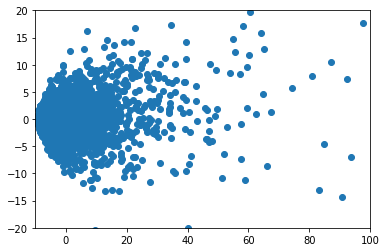

In [152]:
plt.scatter(red[:,0],red[:,1])
plt.xlim(-10, 100)
plt.ylim(-20, 20)
plt.show()

In [153]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=16,max_depth=10)
rfc.fit(X_train_lex,balanced_y_train)
rfc_y = rfc.predict(X_dev_lex)
print(sum(rfc_y==balanced_y_test)/len(balanced_y_test))

0.43665158371040724


In [154]:
error_collection(balanced_test_value_df,balanced_y_test,rfc_y,"balanced_test_lexicon.csv")
print("two_classes_accuracy",two_classes_accuracy(balanced_y_test,rfc_y))

(442,)
(442,)
two_classes_accuracy 0.6244343891402715


In [271]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4, n_init=20, n_jobs=4)
# kmeans.fit(X_train_lex)
# y_km = kmeans.predict(X_dev_lex)
# x_test[y_km==y_test]

In [ ]:
def deepLSTM1_lexi():
    inp = Input(shape=(41,), name='input')
    x = Embedding(10000+2, glove_size, weights=[embedding_matrix], name='embedding')(inp)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1, name='conv1')(x)
    x = MaxPooling1D(pool_size=4, name='maxpool1')(x)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm1')(x)
#     x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm2')(x)

    x = Flatten()(x)
    x = Dense(100, activation='relu', name='dense1')(x)
    x = Dense(50, activation='relu', name='dense2')(x)
    x = Dense(4, activation='sigmoid', name='dense3')(x)
    model = Model(input=inp, output=x)
#     model = Model(outputs=x, inputs=inp)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [55]:
model.fit(X_train_lex.reshape(), cag_y_train, batch_size=32, epochs=10, validation_split=0.1)
print('Acc:', model.evaluate(X_test, cag_y_test, batch_size=32)[1])

0.4421052631578947

### three classes

In [226]:
def getNRCEmotions(lexicondir):
    df = pd.read_csv(os.path.join(lexicondir, 'NRC-emotion-lexicon-wordlevel-v0.92.txt.gz'), sep='\t')
    df.columns = ['word', 'emotion', 'lex-NRC10']
    df = pd.pivot_table(df, values='lex-NRC10', index=['word'], columns=['emotion'])
    df.reset_index(level=0, inplace=True)
    newCols = ['word'] + ['lex-NRC10-' + x for x in df.columns[1:]]
    df.columns = newCols
    return df
lexicon = getNRCEmotions('emd_data/lexicons/')
# (lexicon[lexicon["emotion"]=="positive"]["word"]=="smut")
lexicon[lexicon["word"]=="aback"]["lex-NRC10-negative"]

0    0.0
Name: lex-NRC10-negative, dtype: float64

In [176]:
# lexftr = LexiconFeatures(lexicondir=os.path.join('emd_data/lexicons/'))


In [229]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
example_sent = "This is a sample sentence, showing off the stop words filtration."
  
stop_words = set(stopwords.words('english')) 
  
word_tokens = word_tokenize(example_sent) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
# filtered_sentence = [] 
  
# for w in word_tokens: 
#     if w not in stop_words: 
#         filtered_sentence.append(w) 
print(word_tokens) 
print(filtered_sentence)

['This', 'is', 'a', 'sample', 'sentence', ',', 'showing', 'off', 'the', 'stop', 'words', 'filtration', '.']
['This', 'sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration', '.']
